In [1]:
import cartopy.crs as ccrs
import intake
import numpy as np
import xarray as xr
from tqdm.autonotebook import tqdm
import pyremo as pr
import cordex as cx
import cmaps
import glob
import xesmf as xe
import datetime
from REMO2020_mod import modelclass, open_mfdataset, domainclass, plotclass, remo_plotter_mon

ERROR 1: PROJ: proj_create_from_database: Open of /work/ch0636/g300096/Python/envs/kernel2023/share/proj failed
/tmp/ipykernel_86117/3380618855.py:5: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
from dask.distributed import Client, progress
import dask
dask.config.set({'temporary_directory': '/scratch/g/g300096/dask/tmp'})
client = Client()
client

/work/ch0636/g300096/Python/envs/kernel2023/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44747 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/g300096/levante-spawner-preset//proxy/44747/status,
Dashboard: /user/g300096/levante-spawner-preset//proxy/44747/status,Workers: 16
Total threads: 256,Total memory: 235.37 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39985,Workers: 16
Dashboard: /user/g300096/levante-spawner-preset//proxy/44747/status,Total threads: 256
Started: Just now,Total memory: 235.37 GiB
Comm: tcp://127.0.0.1:35127,Total threads: 16
Dashboard: /user/g300096/levante-spawner-preset//proxy/38193/status,Memory: 14.71 GiB
Nanny: tcp://127.0.0.1:44369,


In [3]:
# define the runs to be plotted
modelruns =[] # init

modelruns.append(modelclass("036030","REMO2020$_{27}$",True))
modelruns.append(modelclass("036032","REMO2020$_{49}$",True))
modelruns.append(modelclass("036039","REMO2020$_{49}$ iMOVE",True))

In [4]:
# give path, prefix and suffix (the main name for the plots)
figpath = './figures/'
prefix = 'SnowCCI_SCFV_mon_'
suffix = 'REMO2020_2749_main'

In [5]:
# REMO and EOBS datapath
rdata = './data_in/model_data/'
snCCidata = './data_in/SnowCCI/'

In [6]:
# define star year and end year
ystart=2001
yend=2010

In [7]:
# Define the order of seasons to be used (also when plotting)
months = ["February","March","April","May"]

In [8]:
# lake fraction cut-off limit
clake = 0.5

In [9]:
# open SnowCCI data
dsSnowCCImon = xr.open_dataset(snCCidata+"SCFV/combined_EUR-11_2001-2010.nc").sel(time=slice(str(ystart), str(yend)))

In [10]:
yearlist = np.arange(ystart,yend+1)
for obj in modelruns:
    for year in yearlist:
        pattern = rdata+"remo_results_"+obj.userexp+"/"+str(year)+"/e"+obj.userexp+"m*.nc"
        obj.filenames += glob.glob(pattern)
    obj.filenames.sort()

In [11]:
# Load the lake mask
lake_mask = xr.open_dataset(rdata+"FLake_input/flake_v3_glcc_defD10.0m_frac_EUR-11.nc")["FLFRA"]

In [12]:
# Months in the SnowCCI data
SnowCCI_mons = [int(ii) for ii in dsSnowCCImon['time.month']]

In [13]:
# Set halo zone length (will be cutted out)
halo = 8

In [14]:
# calculate the T2m difference to EOBS
ii = 0
for obj in modelruns:
    ds = open_mfdataset(obj.filenames, parallel=False, chunks='auto')
    REMOvar = pr.parse_dates(ds)
    REMOvarCCIm = REMOvar.sel(time = np.in1d( REMOvar['time.month'],SnowCCI_mons))
    # Merge data (get identical coordinates)
    data_all = xr.merge([REMOvarCCIm[["CVS"]], dsSnowCCImon/100.0, lake_mask.squeeze().rename("lake_mask")], compat="override", join="override")    
    if (ii == 0):
        data_abs = data_all.scfv.where(data_all.lake_mask < clake, drop=False)
        for mon in months:
            mondata = data_abs.where(data_abs['time.month'] == datetime.datetime.strptime(mon, '%B').month,drop=True).mean(dim="time").expand_dims({"time": [mon]}).squeeze()
            if(mon == months[0]):
                data_absmon = mondata
            else:
                data_absmon = xr.concat([data_absmon,mondata],dim="time", coords="all", compat="override", join="override")
        # cut the halo
        data_absmon = data_absmon.isel(rlat=slice(halo+1,data_absmon.sizes["rlat"]-halo+1), rlon=slice(halo+1,data_absmon.sizes["rlon"]-halo+1)).compute()
    #      
    datadiff = (data_all.CVS-data_all.scfv).where(data_all.lake_mask < clake, drop=False)
    for mon in months:
        mondiffdata = datadiff.where(datadiff['time.month'] == datetime.datetime.strptime(mon, '%B').month,drop=True).mean(dim="time").expand_dims({"time": [mon]}).squeeze()
        if(mon == months[0]):
            obj.vardiff = mondiffdata
        else:
            obj.vardiff = xr.concat([obj.vardiff,mondiffdata],dim="time", coords="all", compat="override", join="override")
    # cut the halo
    obj.vardiff = obj.vardiff.isel(rlat=slice(halo+1,obj.vardiff.sizes["rlat"]-halo+1), rlon=slice(halo+1,obj.vardiff.sizes["rlon"]-halo+1)).compute()
    # not supported, set to zero
    obj.mask = np.zeros(len(months))    
    # increase counter
    ii = ii + 1
    #t_stat
    if(obj.r2020file):
        pole = (ds.rotated_latitude_longitude.grid_north_pole_longitude,ds.rotated_latitude_longitude.grid_north_pole_latitude)

/work/ch0636/g300096/Python/envs/kernel2023/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 57.46 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/work/ch0636/g300096/Python/envs/kernel2023/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 57.46 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/work/ch0636/g300096/Python/envs/kernel2023/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 57.46 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [15]:
# define the domains to be plotted
domaininfo =[] # init
domaininfo.append(domainclass("NEU",[2,54,45,73], hspace=0.3, ylocs=range(-90,90,5)))

In [16]:
# define plotclasses for absolute and difference (model) plots
absplotc = plotclass(label='FSC', lspace=np.linspace(0,1,12), vmin=0, vmax=1, linvert=False, cmapp=cmaps.WhiteBlue)
modplotc = plotclass(label='$\Delta$FSC', lspace=np.linspace(0,1,32), vmin=-0.5, vmax=0.5, linvert=False, cmapp=cmaps.BlueWhiteOrangeRed)

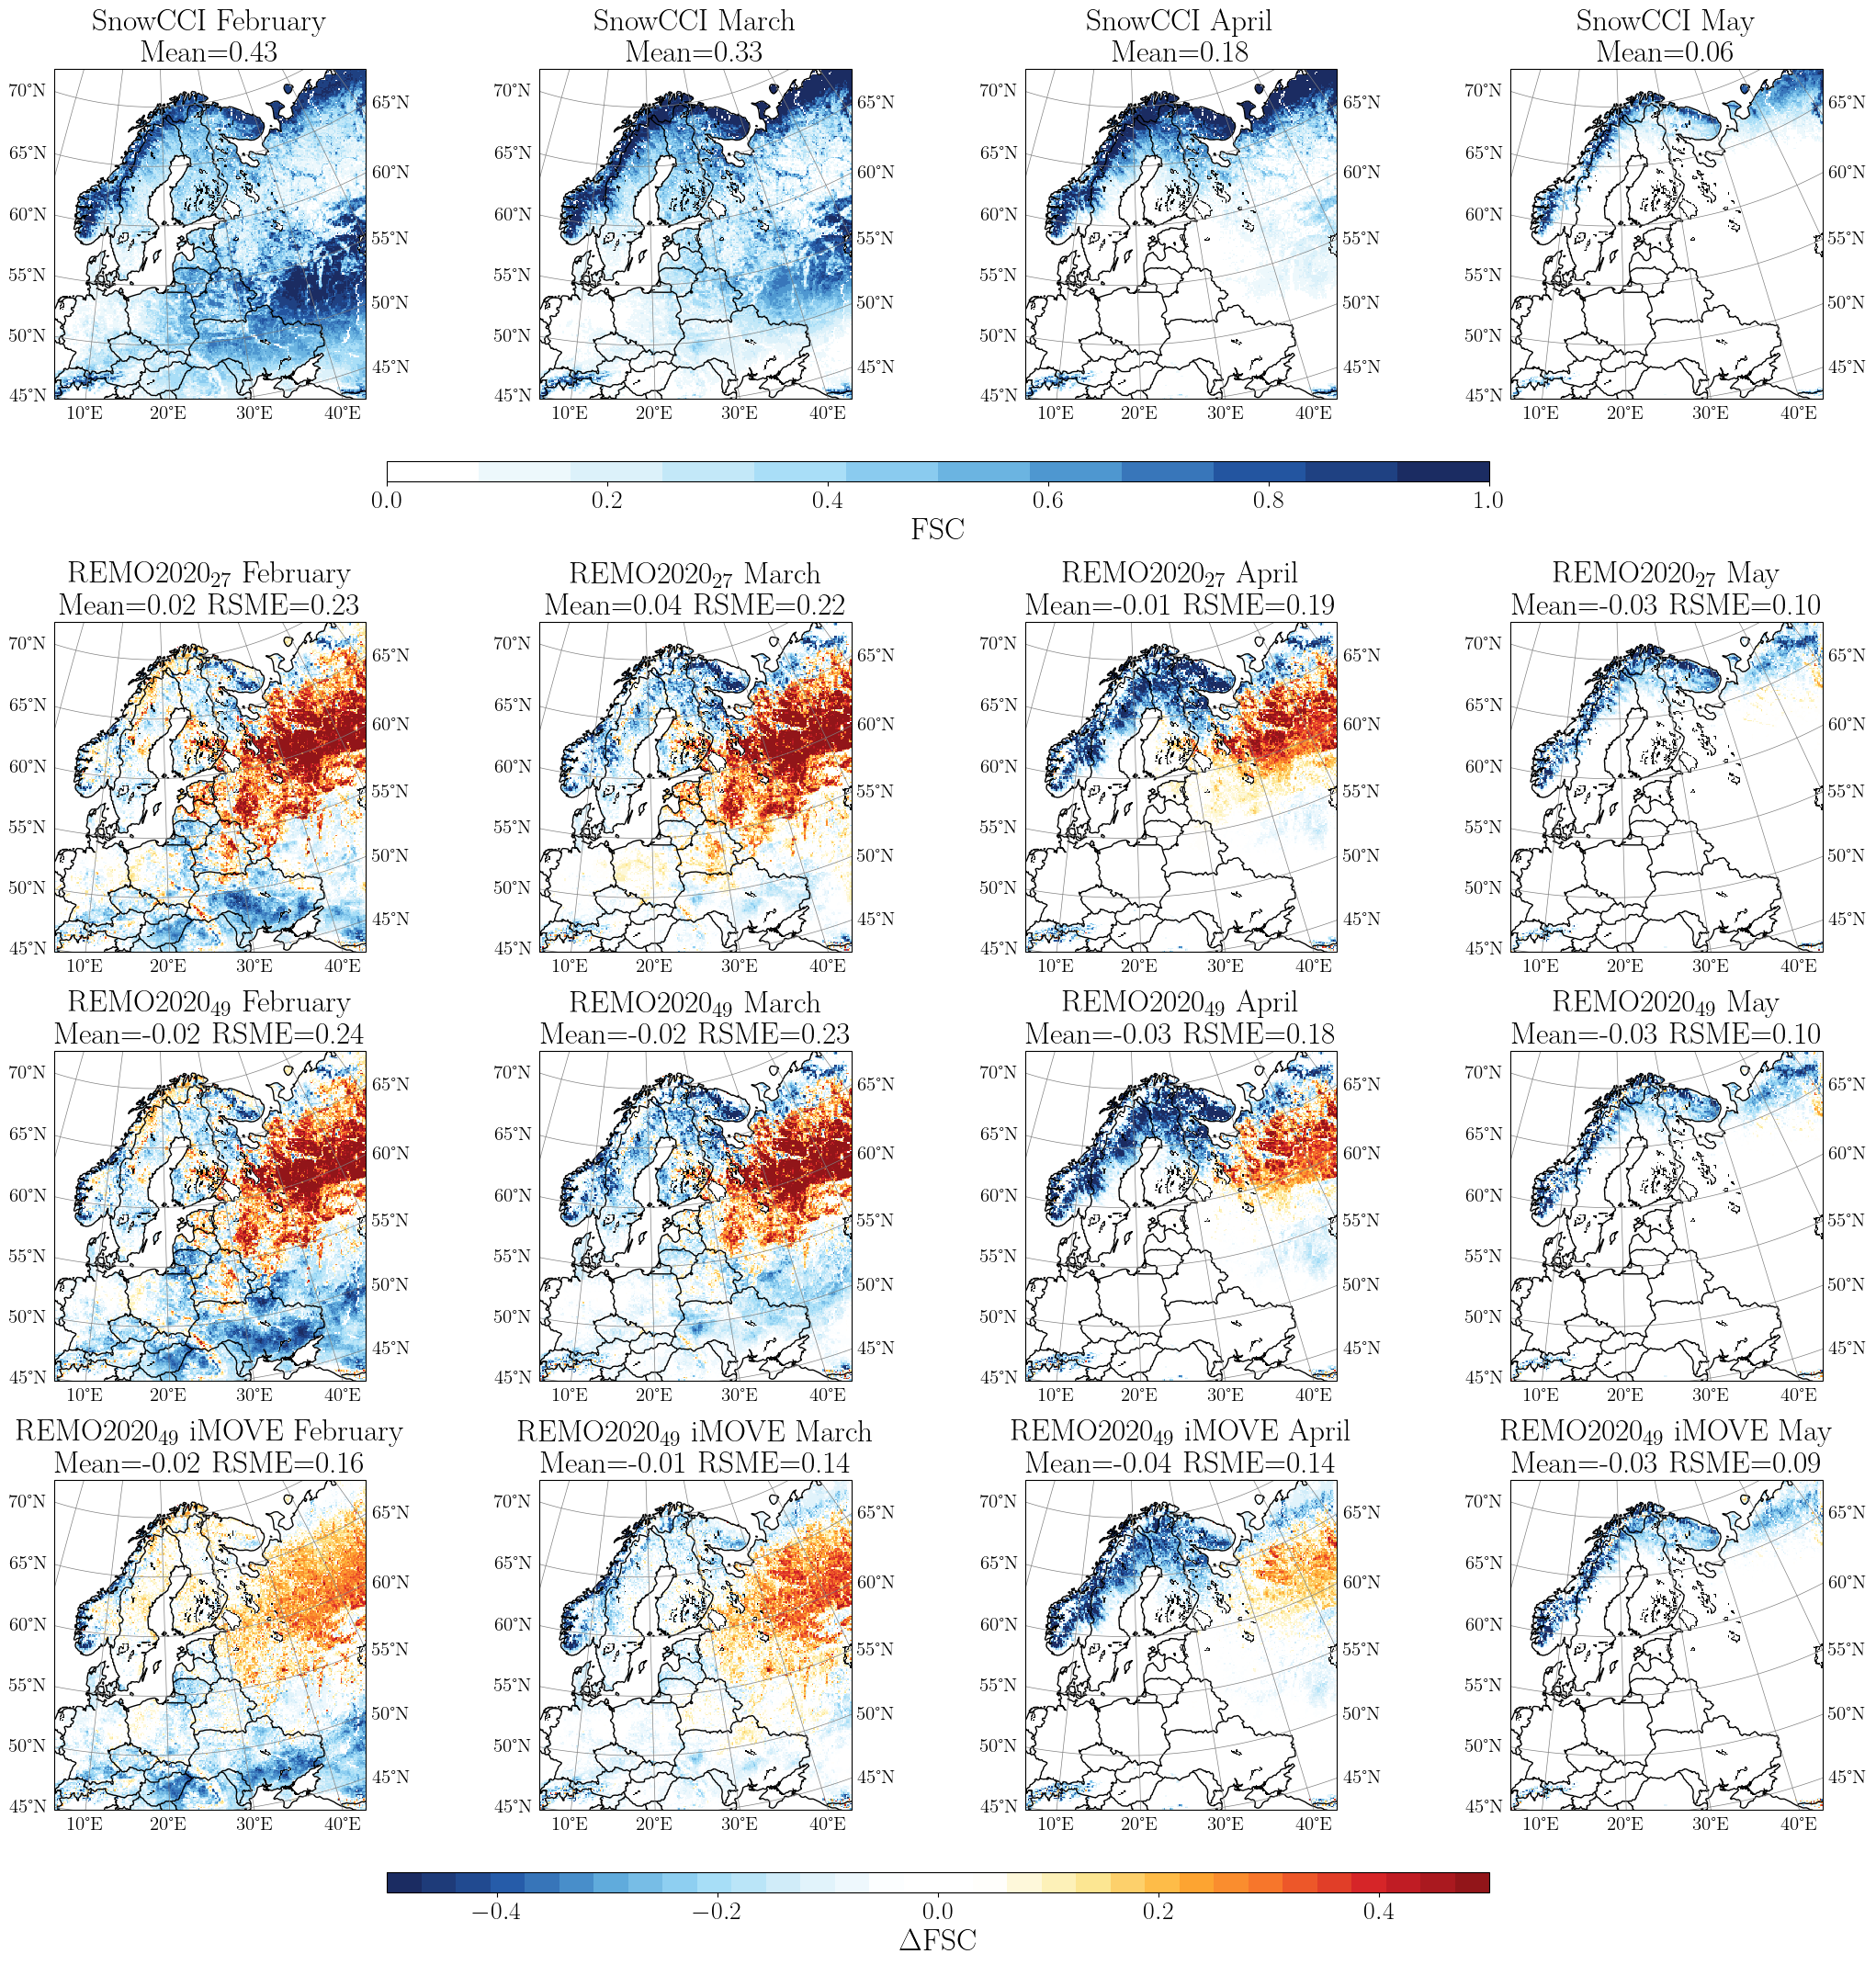

In [17]:
# Loop over domains
for dom in range(len(domaininfo)):
    # Create figure name
    figname=prefix+domaininfo[dom].name+'_'+suffix
    # Call plotter (we can use the eobs plotter directly)
    remo_plotter_mon(absplotc,modplotc,domaininfo[dom],modelruns,"SnowCCI",data_absmon,months,pole,False,figpath,figname)